# Endogenous entrepreneurship and financial frictions

This notebook solves a model of endogenous entrepreneurship with financial frictions.

## The model

### Set up

* There is a continuum of individuals who differ in their wealth $a$ and entrepreneurial ability $z$.

* Each period, every individual chooses to be a Worker or an Entrepreneur.

* Entrepreneurs are subject to a collateral constraint.

* Entrepreneurial ability $z$ is drawn from a Pareto distribution with pdf $\mu\left(z\right)=\eta z^{-\eta-1},z\ge1$. Entrepreneurial ability is persistent: each period a new $z$ is drawn with a probability $\gamma$.

* Financial intermediaries collect deposits and rent out capital to entrepreneurs at rate R, by no arbitrage then $R=r+\delta$ with $r$ the deposit rate.

* There is a representative public firm.

* The government taxes entrepreneurial profits and revenues at rates $\tau^{\pi}$ and $\tau^{y}$ a and rebates all the receipts with lump-sum payments $T_{t}$.

### Individuals' problem

* Individuals have CRRA preferences over consumption 
$$
\max\mathbb{E}_{0}\sum_{t=0}^{\infty}\beta^{t}\frac{c_{t}^{1-\sigma}-1}{1-\sigma},
$$
with inverse elasticity of intertemporal substitution $\sigma$.

* The budget constraint is 
$$
c_{t}+a_{t+1}\le\max\left\{ w_{t},\pi\left(z_{t},a_{t}\right)\right\} +\left(1+r_{t}\right)a_{t}+T_{t},
$$
where the $\max$ operator encompasses the binary occupation choice .

* Profits from operating the production technology are given by
\begin{align*}
\pi\left(z_{t},a_{t}\right)	&=	\max_{l_{t},k_{t}}\left\{ \left(1-\tau_{t}^{\pi}\right)\left[\left(1-\tau_{t}^{y}\right)z_{t}Z_{t}\left(k_{t}^{\alpha}l_{t}^{1-\alpha}\right)^{1-\nu}-w_{t}l_{t}-\left(\delta+r_{t}\right)k_{t}\right]\right\}, \\
\text{s.t.}		\quad &k_{t}\le\lambda a_{t}.
\end{align*}

* Hence individuals at productivity $z_{t}$ choose to become entrepreneurs if their wealth exceeds the threshold value $\bar{a}\left(z_{t}\right)$ that solves
$$
w_{t}=\pi\left(z_{t},\bar{a}\left(z_{t}\right)\right).
$$

* The technology operated by individual entrepreneurs features decreasing returns to scale
$$
y_{t}=f\left(z,k,l\right)=zZ_{t}\left(k^{\alpha}l^{1-\alpha}\right)^{1-\nu},
$$
with $Z_{t}$ aggregate TFP shocks.


### Public firm

* A representative public firm operates the CRS technology
$$
F\left(K_{ct},L_{ct}\right)=Z_{t}Z_{ct}K_{ct}^{\alpha}L_{ct}^{1-\alpha}.
$$

* From FOCs:
\begin{align*}
r_{t}	&=	F_{K}\left(K_{ct},L_{ct}\right)-\delta =	\alpha Z_{t}Z_{ct}\left(\frac{K_{ct}}{L_{ct}}\right)^{\alpha-1}-\delta, \\
    w_{t}	&=	F_{L}\left(Z_{ct},K_{ct},L_{ct}\right) =	\left(1-\alpha\right)Z_{t}Z_{ct}\left(\frac{K_{ct}}{L_{ct}}\right)^{\alpha},
\end{align*}
and so capital-labor ratio
$$
\frac{K_{ct}}{L_{ct}} =	\left(\frac{\alpha Z_{t}Z_{ct}}{r_{t}+\delta}\right)^{\frac{1}{1-\alpha}}.
$$

### Equilibrium

Given an initial distribution $D_{0}\left(z,a\right)$, a competitive equilibrium is allocations $\{ c_{t}\left(z_{t},a_{t}\right)$,$a_{t+1}\left(z_{t},a_{t}\right)$,$l_{t}\left(z_{t},a_{t}\right)$,$k_{t}\left(z_{t},a_{t}\right)\}$ , distributions $D_{t}\left(z_{t},a_{t}\right)$ , and prices $\{ w_{t}$,$r_{t}\}$  such that

1. Given prices, the policy functions solve the individuals' problem.

2. Labor market clears:
$$
L_{ct}+\int_{E}l_{t}\left(z,a\right)dD_{t}\left(a,z\right)-\int_{W}dD_{t}\left(a,z\right)=0.
$$

3. Asset market clears:
$$
K_{ct}+\int_{E}k_{t}\left(z,a\right)dD_{t}\left(a,z\right)-\int aD_{t}\left(a,z\right)=0.
$$

4. Goods market clears (by Walras's Law).

5. The government's budget is balanced
$$
T_{t}=\int_{E}\left[\left(\tau_{t}^{\pi}+\tau_{t}-\tau_{t}^{\pi}\tau_{t}\right)y_{t}\left(z,k,l\right)-\tau_{t}^{\pi}\left(w_{t}l_{t}\left(z,a\right)+\left(\delta+r_{t}\right)k_{t}\left(z,a\right)\right)\right]dD_{t}\left(a,z\right).
$$

6. The joint distribution evolves according to
\begin{align*}
D_{t+1}^{E}\left(a_{t+1},z_{t+1}\right)	&=	\gamma D_{t}^{E}\left(a_{t+1}^{-1}\left(z_{t},a_{t}\right),z_{t}\right)+\left(1-\gamma\right)\int_{z}D_{t}^{E}\left(a_{t+1}^{-1}\left(z_{t},a_{t}\right),z_{t}\right),\\
	&=	\left[\gamma I+\left(1-\gamma\right)\Pi\right]D_{t}^{E}\left(a_{t+1}^{-1}\left(z_{t},a_{t}\right),z_{t}\right),
\end{align*}
where $\Pi=\left[\begin{array}{c}
\pi_{z}\\
\pi_{z}\\
\ldots
\end{array}\right]$.

## Solving the model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq
from household import get_coh, agrid, pareto_discrete
from aux import interpolate_y, invdist

### A. Solving for entrepreneurial profits

The indirect profit function is
\begin{align*}
\pi\left(z_{t},a_{t}\right)	&=	\max_{l_{t},k_{t}}\left\{ \left(1-\tau_{t}^{\pi}\right)\left[\left(1-\tau_{t}^{y}\right)z_{t}Z_{t}\left(k_{t}^{\alpha}l_{t}^{1-\alpha}\right)^{1-\nu}-w_{t}l_{t}-\left(\delta+r_{t}\right)k_{t}\right]\right\}, \\
\text{s.t.}		\quad &k_{t}\le\lambda a_{t}.
\end{align*}

1. If the collateral constraint does not bind, profit maximization implies
$$
k^{u}\left(z_{t}\right)	=	\left[\left(1-\tau_{t}^{y}\right)z_{t}Z_{t}\right]^{\frac{1}{\nu}}\left(\frac{\alpha\left(1-\nu\right)}{r_{t}+\delta}\right)^{\frac{1-\left(1-\alpha\right)\left(1-\nu\right)}{\nu}}\left(\frac{\left(1-\alpha\right)\left(1-\nu\right)}{w_{t}}\right)^{\frac{\left(1-\alpha\right)\left(1-\nu\right)}{\nu}}.
$$

2. If the collateral constraint binds (with $\theta$ the Lagrange multiplier)
$$
k^{c}\left(a_{t}\right)	=	\lambda a_{t}.
$$

Hence the capital policy function is
$$
k\left(z_{t},a_{t}\right)=\min\left\{ k^{c}\left(a_{t}\right),k^{u}\left(z_{t}\right)\right\} .
$$
and the labor policy function is 
$$
l\left(z_{t},a_{t}\right)=\left(\frac{\left(1-\alpha\right)\left(1-\nu\right)\left(1-\tau_{t}^{y}\right)z_{t}Z_{t}}{w_{t}}\right)^{\frac{1}{1-\left(1-\alpha\right)\left(1-\nu\right)}}k\left(z_{t},a_{t}\right)^{\frac{\alpha\left(1-\nu\right)}{1-\left(1-\alpha\right)\left(1-\nu\right)}}.
$$
and the indirect profit function is given by 
$$
\pi\left(z_{t},a_{t}\right)=\left(1-\tau_{t}^{\pi}\right)\left[\left(1-\tau_{t}^{y}\right)z_{t}Z_{t}\left(k\left(z_{t},a_{t}\right)^{\alpha}l\left(z_{t},a_{t}\right)^{1-\alpha}\right)^{1-\nu}-w_{t}l\left(z_{t},a_{t}\right)-\left(\delta+r_{t}\right)k\left(z_{t},a_{t}\right)\right].
$$
Note that the tax on profits $\tau_{t}^{\pi}$ does not affect the optimal policies, while the tax on revenue $\tau_{t}^{y}$ does.

Indirect profit function:

In [2]:
def profit_pol(a, z, r, w, lam, delta, alpha, nu, tau_pi, tau_y, Z_e, Z):
    """Solve for the indirect profit function given asset and producitivty grids and parameters."""

    # capital policy: unconstrained
    k_d_unconst = np.maximum(
        0, ((1 - tau_y) * z * Z_e * Z) ** (1 / nu) *
           (alpha * (1 - nu) / (r + delta)) ** ((1 - (1 - alpha) * (1 - nu)) / nu) *
           ((1 - alpha) * (1 - nu) / w) ** ((1 - alpha) * (1 - nu) / nu))

    if lam < np.inf:
        # capital policy: constrained
        k_d_const = np.maximum(0, lam * a)
        # index of unconstrained states (z_grid,a) where optimal k <= lambda*a
        unconst = (k_d_unconst[:, np.newaxis] <= k_d_const).astype(float)
        # overall capital policy
        k_d = np.minimum(k_d_const, k_d_unconst[:, np.newaxis])
    else:
        unconst = np.ones((len(z), len(a)))
        k_d = np.ones((len(z), len(a))) * k_d_unconst[:, np.newaxis]  # if no constraint

    if isinstance(r, float) or isinstance(r, int):
        if any(1-unconst[:, -1]):
            raise ValueError(f'Upper bound of asset grid {a[-1]:.2f} is not large enough!')
    else:
        if any(1-unconst[:, :, -1].ravel()):
            raise ValueError(f'Upper bound of asset grid {a[-1]:.2f} is not large enough!')

    # overall labor policy
    l_d = (((1 - alpha) * (1 - nu) * (1 - tau_y) * z * Z_e * Z / w) ** (1 / (1 - (1 - alpha) * (1 - nu))))[:,
            np.newaxis] * (k_d) ** (alpha * (1 - nu) / (1 - (1 - alpha) * (1 - nu)))

    # overall output and indirect profit function
    y_e = z[:, np.newaxis] * Z_e * Z * (k_d) ** (alpha * (1 - nu)) * (l_d) ** ((1 - alpha) * (1 - nu))
    pi = (1 - tau_pi) * ((1 - tau_y) * y_e - (r + delta) * k_d - w * l_d)

    # occupational choice (1: entrepreneur, 0: worker)
    entrep = (pi >= w).astype(float)

    return entrep*pi, entrep*k_d, entrep*l_d, unconst, entrep*y_e, entrep

Compute marginal profits $\frac{\partial \pi(a,z)}{\partial a}$

In [3]:
def d_profit(a, z, r, w, lam, delta, alpha, nu, tau_pi, tau_y, Z_e, Z, da=1e-5):
    """Returns numerical derivative of profits wrt assets."""
    
    a_scaled = a + (a == 0) * a[1] * 1e-1
    profit_up, _, _, _, _, _ = profit_pol(
        a_scaled + da, z, r, w, lam, delta, alpha, nu, tau_pi, tau_y, Z_e, Z)
    profit_down, _, _, _, _, _ = profit_pol(
        a_scaled - da, z, r, w, lam, delta, alpha, nu, tau_pi, tau_y, Z_e, Z)
    return (profit_up - profit_down) / (2 * da)

Return all production outputs from the primitives:

In [4]:
def prod(a_grid, z_grid, r, w, lam, delta, alpha, nu, tau_pi, tau_y, Z_e, Z, theta):
    """Returns all production outcomes given grids and parameters."""
    
    # Get profits and policies
    pi, k_d, l_d, unconst, y_e, entrep = profit_pol(
        a_grid, z_grid, r, w, lam, delta, alpha, nu, tau_pi, tau_y, Z_e, Z)
    # marginal profit: dpi/da
    dpi = d_profit(a_grid, z_grid, r, w, lam, delta, alpha, nu, tau_pi, tau_y, Z_e, Z)
    # labor supply
    l_w = (1 - entrep) * z_grid[:, np.newaxis] ** theta
    # effective return: r + dpi/da
    reff = r + entrep * dpi

    return pi, k_d, l_d, unconst, entrep, dpi, y_e, l_w, reff

Simple helper functions used later.

In [5]:
def KL_from_r(r, alpha, delta, Z_c, Z):
    """Computes K/L ratio in public sector from interest rate"""
    return (alpha * Z * Z_c / (r + delta)) ** (1 / (1 - alpha))

def w_from_KL(KL, alpha, Z_c, Z):
    """Computes wage from K/L ratio in public sector"""
    return (1 - alpha) * Z_c * Z * (KL) ** (alpha)

def w_from_r(r, alpha, delta, Z_c, Z):
    """Computes wage rate from interest rate"""
    return (1 - alpha) * Z_c * Z * (alpha * Z * Z_c / (r + delta)) ** (alpha / (1 - alpha))

### B. Solving the individuals' problem

We can write the Bellman as
\begin{align*}
v_{t}\left(a_{t},z_{t}\right)	&=	\max_{c_{t},a_{t+1}}\left\{ u\left(c_{t}\right)+\beta\left[\gamma v_{t+1}\left(a_{t+1},z_{t}\right)+\left(1-\gamma\right)\int v_{t+1}\left(a_{t+1},z_{t+1}\right)\mu\left(z_{t+1}\right)dz_{t+1}\right]\right\}, \\
\text{s.t.}	\quad &	c_{t}+a_{t+1}=M\left(a_{t+1},z_{t}\right)+\left(1+r_{t}\right)a_{t}+T_{t},
\end{align*}
where $M\left(a_{t+1},z_{t}\right)=\max\left\{ w_{t},\pi\left(z_{t},a_{t}\right)\right\}$ and the Euler equation is 
\begin{align*}
u'\left(c_{t}\left(z_{t},a_{t}\right)\right)=&\beta\bigg[\gamma\left(1+r_{t+1}^{eff}\left(z_{t},a_{t+1},d_{t+1}\right)\right)u'\left(c_{t+1}\left(z_{t},a_{t+1}\right)\right),\\
&\quad+\left(1-\gamma\right)\int\left(1+r_{t+1}^{eff}\left(z_{t+1},a_{t+1},d_{t+1}\right)\right)u'\left(c_{t+1}\left(z_{t+1},a_{t+1}\right)\right)\mu\left(z_{t+1}\right)dz_{t+1}\bigg],
\end{align*}
where the net effective return is defined as 
$$
r_{t}^{eff}\left(z_{t},a_{t}\right)=\begin{cases}
r_{t} & \text{if Worker},\\
r_{t}+\frac{\partial\pi\left(z_{t},a_{t}\right)}{\partial a_{t}} & \text{if Entrepreneur},
\end{cases} 
$$
where
$$\frac{\partial\pi\left(z_{t},a_{t}\right)}{\partial a_{t}}=\begin{cases}
\frac{\partial\pi^{const}\left(z_{t},a_{t}\right)}{\partial a_{t}} & \text{if constrained Entrepreneur},\\
0 & \text{if unconstrained Entrepreneur}.
\end{cases}
$$

**Obtaining policies.**
* Inputs: prices $\left\{ w_{t},r_{t}\right\}$ , government policy $\left\{ \tau_{t}^{\pi},T_{t}\right\}$  and consumption on next period's asset grid $c_{t+1}\left(z_{t+1},a_{t+1}\right)$.

* Calculate income $M\left(a_{t+1},z_{t}\right)$ on the grids for $a$ and $z$ from the indirect profit function.

* Calculate next period's cash-on-hand on the grids for $a$ and $z$ 
$$
coh\left(z_{t+1},a_{t+1}\right)	=	M\left(z_{t+1},a_{t+1}\right)+\left(1+r_{t}\right)a_{t+1}+T_{t}.
$$

* Compute the RHS of the Euler equation 
\begin{align*}
RHS\left(a_{t+1},z_{t}\right)	&=	\beta\bigg[\gamma\bigg\{\left(1+r_{t+1}^{eff}\left(z_{t},a_{t+1}\right)\right)u'\left(c_{t+1}\left(z_{t},a_{t+1}\right)\right)\\
		&\quad+\left(1-\gamma\right)\int\bigg\{\left(1+r_{t+1}^{eff}\left(z_{t+1},a_{t+1}\right)\right)u'\left(c_{t+1}\left(z_{t+1},a_{t+1}\right)\right)\bigg\}\mu\left(z_{t+1}\right)dz_{t+1}\bigg],
\end{align*}
and invert to get current consumption 
$$
c\left(a_{t+1},z_{t}\right)=u^{-1}\left(RHS\left(a_{t+1},z_{t}\right)\right).
$$

* Calculate the asset policy functions with the mapping from assets today 
$$
a_{t}=\frac{c_{t}\left(a_{t+1},z_{t}\right)+a_{t+1}-M\left(a_{t+1},z_{t}\right)-T_{t}}{1+r_{t}} ,
$$
to assets tomorrow $a_{t+1}$ that we can invert by interpolation to get the policy function $a_{t+1}\left(a_{t},z_{t}\right)$.

* Enforce the borrowing constraint, ie enforce $a_{t+1}\left(a_{t},z_{t}\right)\ge0$.

* Compute the consumption policy functions as
$$
c_{t}\left(a_{t},z_{t}\right)=coh\left(z_{t},a_{t}\right)-a_{t+1}\left(a_{t},z_{t}\right),
$$
and if $c_{t}\left(a_{t},z_{t}\right)<0$, set $c_{t}\left(a_{t},z_{t}\right)=0$ and $a_{t+1}\left(a_{t},z_{t}\right)=coh\left(z_{t},a_{t}\right)$.


**Obtaining the distribution.**

* Given a distribution at $t$, the distribution at $t+1$ is obtained as 
$$
D_{t+1}\left(a_{t+1},z_{t+1}\right)=\gamma D_{t}\left(a_{t+1}^{-1}\left(z_{t},a_{t};w,r\right),z_{t}\right)+\left(1-\gamma\right)\sum_{\hat{z}\in\mathcal{Z}}\mu\left(\hat{z}\right)D_{t}\left(a_{t+1}^{-1}\left(\hat{z},a_{t};w,r\right),\hat{z}\right),
$$
and the stationary distribution is obtained by iterating until convergence.

* In matrix form, we stack the vector $\mu\left(z\right)$ in a matrix $\Pi$ and we can do
$$
D_{t+1}\left(a_{t+1},z_{t+1}\right)=\left(\gamma I+\left(1-\gamma\right)\Pi\right)D_{t}\left(a_{t+1}^{-1}\left(z_{t},a_{t};w,r\right),z_{t+1}\right).
$$

Backward iteration function:

In [6]:
def household_backward(Va_p, a_grid, z_grid, theta, Pi_p, w, r, reff, Tr, beta, eis, pi, entrep):
    """Backward iteration step of the household problem: get consumption today from consumotion
    tomorrow using endogenous grid point."""

    # marginal utility from next period value on next peridod's asset grid
    uc_nextgrid = (beta * Pi_p) @ Va_p

    # consumption today on next peridod's asset grid from Euler equation
    c_nextgrid = uc_nextgrid ** (-eis)

    # cash-on-hand
    coh = get_coh(w, z_grid, theta, pi, r, a_grid, Tr)

    # interpolate to get mapping of cash-on-hand in each state to assets next period from budget constraint
    a = np.empty_like(coh)
    for s in range(coh.shape[0]):
        a[s, :] = interpolate_y(c_nextgrid[s, :] + a_grid, coh[s, :], a_grid)

    # replace constrained asset choices
    a[a < a_grid[0]] = a_grid[0]

    # compute consumption
    c = coh - a
    c[c <= 0], a[c <= 0] = 1e-4, coh[c <= 0]  # enforce positive consumption

    # derivative of value function
    Va = (1 + reff) * c ** (-1 / eis)

    # asset policy of entrepreneurs and workers
    ae, aw = a * entrep, a * (1 - entrep)

    return Va, a, ae, aw, c

Given prices $(r,w)$ and transfers $T$, finf Partial Equilibrium (PE) outcomes: iterate backwards to obtain policies, and iterate foward to obtain distribution.

In [7]:
def pe_ss(Va_old, r, w, Tr, Pi, beta, eis, a_grid, z_grid, lam, delta, alpha, nu, tau_pi,
          tau_y, Z_e, Z, theta, maxit=5000, atol=1E-8):
    """Given prices, iterates backward to get steady-state policy rule using household_backward()
    and iterates forward using invdist() to get steady-state distribution of agents"""

    # production outcomes
    pi, k_d, l_d, unconst, entrep, dpi, y_e, l_w, reff = prod(
        a_grid, z_grid, r, w, lam, delta, alpha, nu, tau_pi, tau_y, Z_e, Z, theta)

    # backward iteration loop  to obtain policies
    for it in range(maxit):
        Va, a, ae, aw, c = household_backward(
            Va_old, a_grid, z_grid, theta, Pi, w, r, reff, Tr, beta, eis, pi, entrep)
        if it % 10 == 0 and np.max(np.abs(Va - Va_old)) < atol:
            break
        Va_old = Va
    assert it < maxit - 1, 'never converged after %d iterations!' % maxit

    # forward iteration loop to obtain distributions
    Dst = invdist(a_grid, a, Pi)

    return {'Va': Va, 'a': a, 'c': c, 'Dst': Dst, 'entrep': entrep, 'theta': theta,
            'K_D': np.sum(Dst * k_d), 'L_D': np.sum(Dst * l_d), 'L_W': np.sum(Dst * l_w),
            'A': np.sum(Dst * a), 'C': np.sum(Dst * c), 'Y_E': np.sum(Dst * y_e),
            'AW': np.sum(Dst * aw), 'AE': np.sum(Dst * ae), 'ENTREP': np.sum(Dst * entrep)}

### C. Algorithm to solve for the general equilibrium

1. Fix grid for states $a$ and $z$

2. Set a guess for the interest rate $r$

3. Given $r$, use the public sector to find $w$

4. Given prices $(r,w)$, and a guess for $T$, find the individuls' policy functions

5. Given policies, find the stationary distribution

6. Compute the implied transfers $T$ and if not close, use the updated $T$ and go back to step 4.

7. Aggregate policies and distributions to find assets and savings of the private sector and back out $K_{c}$ from asset market clearing condition

8. Compute error in labor market and update $r$ until convergence.


Given prices $(r,w)$, solve for transfers $T$:

In [8]:
def solve_T(w, r, a_grid, z_grid, theta, Pi, beta, eis, lam, delta, alpha, nu, tau_pi, tau_y, Z_e, Z,
            Tr=.0, atol=1e-4, noisy=False, maxit=50):
    """Solves the fixed point for government transfers such that government budget constraint holds."""
    pi, _, _, _, _, _, _, _, reff = prod(
        a_grid, z_grid, r, w, lam, delta, alpha, nu, tau_pi, tau_y, Z_e, Z, theta)
    Va = (1 + reff) * np.maximum(1E-8, get_coh(w, z_grid, theta, pi, r, a_grid, Tr) - a_grid) ** (-1 / eis)
    if (tau_pi == 0.) & (tau_y == 0.):
        # if no taxes are set, return PE outcomes
        ss = pe_ss(Va, r, w, Tr, Pi, beta, eis, a_grid, z_grid, lam, delta, alpha, nu, tau_pi, tau_y, Z_e, Z, theta)
    else:
        for it in range(maxit):
            # get PE outcomes
            ss = pe_ss(Va, r, w, Tr, Pi, beta, eis, a_grid, z_grid, lam, delta, alpha, nu, tau_pi, tau_y, Z_e, Z, theta)
            # compute transfers consistent with government revenue
            Tr_new = (tau_pi + tau_y - tau_pi*tau_y) * ss['Y_E'] - tau_pi * ((r + delta) * ss['K_D'] + w * ss['L_D'])
            if np.max(np.abs(Tr_new - Tr)) < atol:
                break
            if noisy:
                print(f'    Tr = {Tr:.6f},  error = {np.max(np.abs(Tr_new - Tr)):.6f}')
            Tr = Tr_new
        assert it < maxit - 1, 'lump-sum transfers never converged after %d iterations!' % maxit

    return ss

Return error in labor market clearing condition at given interst rate:

In [9]:
def labor_market_err(r, a_grid, z_grid, theta, Pi, beta, eis, lam, delta, alpha, nu, tau_pi,
                     tau_y, Z_c, Z_e, Z, Tr, atol=1e-4, noisy=False):
    """Return excess labor demand at given interest rate"""

    KL_c = KL_from_r(r, alpha, delta, Z_c, Z)  # K/L ratio in public sector from r
    w = w_from_KL(KL_c, alpha, Z_c, Z)  # wage from K/L in public sector

    # compute steady-state
    ss = solve_T(w, r, a_grid, z_grid, theta, Pi, beta, eis, lam, delta, alpha, nu, tau_pi, tau_y, Z_e, Z,
                 Tr=Tr, atol=atol, noisy=noisy)

    K_c = np.maximum(ss['A'] - ss['K_D'], 1e-7)  # capital in public sector from asset market clearing
    L_c = K_c / KL_c  # labor in public sector from K and K/L
    err = L_c + ss['L_D'] - ss['L_W']  # return excess labor demand

    if noisy: print(f'r = {r:.6f},  error = {err:.6f}')

    return err

Solve for general equilibrium:

In [10]:
def ge_ss(beta=.9115, eis=.5, lam=3, delta=.06, alpha=.33, nu=.5, tau_pi=0., tau_y=0., Z_c=1.,
          Z_e=1., Z=1., theta=.0, gamma=0.894, N_z=42, eta=4.15, amax=1800, N_a=1300,
          Tr=0., atol=1e-4, maxit=50, rl=.08, rh=.09, noisy=True):
    """Solves for general equilibrium: find interest rate r and transfers Tr such that asset market
    clearing condition and governmetn budget constraint hold."""

    # Productivity grid
    z_grid, pi_z = pareto_discrete(eta, N_z)
    Pi = gamma * np.eye(len(z_grid)) + (1 - gamma) * np.tile(pi_z, (len(pi_z), 1))

    # Asset grid
    a_grid = agrid(amax, N_a)  # amax must be big enough

    # solve for r
    r = brentq(labor_market_err, rl, rh, xtol=atol, maxiter=maxit,
               args=(a_grid, z_grid, theta, Pi, beta, eis, lam, delta, alpha, nu,
                     tau_pi, tau_y, Z_c, Z_e, Z, Tr, atol, noisy))
    w = w_from_r(r, alpha, delta, Z_c, Z)  # wage w at given r

    #  steady-state st given prices (r,w)
    ss = solve_T(w, r, a_grid, z_grid, theta, Pi, beta, eis, lam, delta, alpha, nu,
                 tau_pi, tau_y, Z_e, Z, Tr=Tr, atol=atol, noisy=noisy)

    # public sector
    ss['K_c'] = np.maximum(ss['A'] - ss['K_D'], 1e-7)  # capital in public sector from asset market clearing
    ss['L_c'] = ss['L_W'] - ss['L_D']  # labor in public sector from K and K/L
    ss['Y_c'] = Z * Z_c * ss['K_c'] ** alpha * ss['L_c'] ** (1 - alpha)  # output in public sector
    ss['KL'] = ss['K_c'] / ss['L_c']

    # aggregate output
    ss['Y'] = ss['Y_c'] + ss['Y_E']  # aggregate output

    return {**ss, 'r': r, 'w': w, 'beta': beta, 'eis': eis, 'lam': lam, 'delta': delta, 'alpha': alpha, 'Pi': Pi,
             'nu': nu, 'tau_pi': tau_pi, 'tau_y': tau_y, 'Z_c': Z_c, 'Z_e': Z_e, 'Z': Z, 'amax': amax,
            'K': ss['K_c'] + ss['K_D'], 'KY': (ss['K_c'] + ss['K_D'])/ss['Y'], 'a_grid': a_grid, 'z_grid': z_grid,
            'AY': ss['A']/ss['Y'], 'AEY': ss['AE']/ss['Y'], 'AWY': ss['AW']/ss['Y']}

Compute steady-state:

In [11]:
ss = ge_ss()

r = 0.080000,  error = -0.744410
r = 0.090000,  error = 0.068694
r = 0.089155,  error = -0.073654
r = 0.089592,  error = 0.004934
r = 0.089542,  error = -0.002379


## Visualize equilibrium

Let's look at the occupational choice. 

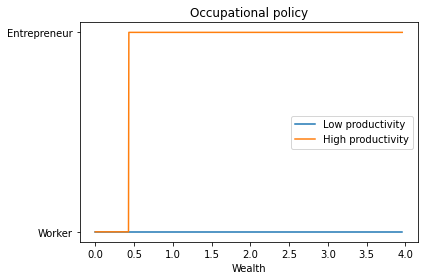

In [12]:
max_a_o_pol = 4
maxx_o_pol = np.argmin(np.abs(ss['a_grid'] - max_a_o_pol))
states_o_pol = [6, 10]
labls = ['Low productivity', 'High productivity']

for i, s in enumerate(states_o_pol):
    plt.plot(ss['a_grid'][:maxx_o_pol], ss['entrep'][s, :maxx_o_pol], label=labls[i])
plt.title('Occupational policy'), plt.xlabel('Wealth')
plt.yticks([0,1], ['Worker', 'Entrepreneur'])
plt.legend()
plt.tight_layout()
plt.show()

We see that low productivity individuals do not chose to become entrepreneurs at all levels of wealth given the low potential profits they would generate. 
On the other hand, high productivity individuals, chose to become entrepreneurs at fairly low levels of assets. 

Let's now look at the wealth distribution.

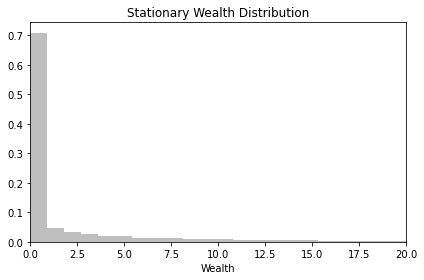

In [13]:
plt.hist(ss['a_grid'], weights=np.sum(ss['Dst'], axis=0) / np.sum(ss['Dst']),
         bins=2000, color='gray', alpha=0.5)
plt.xlabel('Wealth')
plt.xlim(0, 20)
plt.title('Stationary Wealth Distribution')
plt.tight_layout()
plt.show()

The endogenous distribution of wealth inherited the properties of the distribution of entrepreneurial skills and hence features a fat tail.

Let's visualize the asset market equilibrium.

In [14]:
rvec = np.array([.08, .085, .088, .09, .092, .094])
VARS = ['A', 'K_D', 'L_D', 'L_W', 'ENTREP']
x = {key: np.empty(len(rvec)) for key in VARS + ['K_c', 'L_c']}
for i, r_i in enumerate(rvec):
    sspe = solve_T(ss['w'], r_i, ss['a_grid'], ss['z_grid'], ss['theta'], ss['Pi'], ss['beta'], ss['eis'], ss['lam'], ss['delta'], ss['alpha'], ss['nu'], ss['tau_pi'], ss['tau_y'], ss['Z_e'], ss['Z'])
    for var in VARS:
        x[var][i] = sspe[var]
for i, r_i in enumerate(rvec):
    x['K_c'][i] = KL_from_r(r_i, ss['alpha'], ss['delta'], ss['Z_c'], ss['Z']) * ss['L_c']
    x['L_c'][i] = ss['K_c'] / KL_from_r(r_i, ss['alpha'], ss['delta'], ss['Z_c'], ss['Z'])

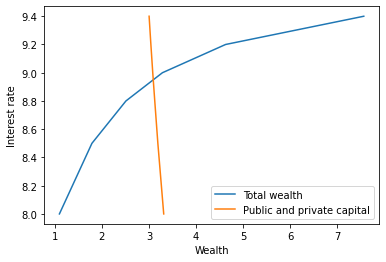

In [15]:
plt.plot(x['A'], rvec*100, label='Total wealth')
plt.plot(x['K_D']+x['K_c'], rvec*100, label='Public and private capital')
plt.legend()
plt.ylabel('Interest rate'), plt.xlabel('Wealth')
plt.show()